In [1]:
import numpy as np

def generate_initial_hypotheses(C=2.5, range_width=5):
    """
    Generate initial hypotheses for weight values centered around C with given range.
    
    Parameters:
    C (float): The center value for the hypotheses range.
    range_width (float): The total width of the range to consider for hypotheses.

    Returns:
    List[float]: A list of hypothesis values.
    """
    hypotheses = []
    min_value = C - range_width / 2
    max_value = C + range_width / 2

    # Iterate over possible exponents and most significant bits of the mantissa
    for exponent in range(256):  # 8 bits for exponent
        for mantissa in range(256):  # 8 most significant bits for mantissa
            int_value = (exponent << 23) | (mantissa << 15)
            float_value = np.frombuffer(int_value.to_bytes(4, byteorder='little'), dtype=np.float32)[0]
            
            # Filter the hypotheses to keep only those in the specified range
            if min_value <= float_value <= max_value:
                hypotheses.append(float_value)

    return hypotheses

# Generate initial hypotheses with a center value C and a range width
initial_hypotheses = generate_initial_hypotheses(C=2.5, range_width=5.0)
print("Number of hypotheses generated:", len(initial_hypotheses))
print("Some example hypotheses:", initial_hypotheses[:10])



Number of hypotheses generated: 33089
Some example hypotheses: [0.0, 4.5918e-41, 9.1835e-41, 1.37753e-40, 1.83671e-40, 2.29589e-40, 2.75506e-40, 3.21424e-40, 3.67342e-40, 4.1326e-40]


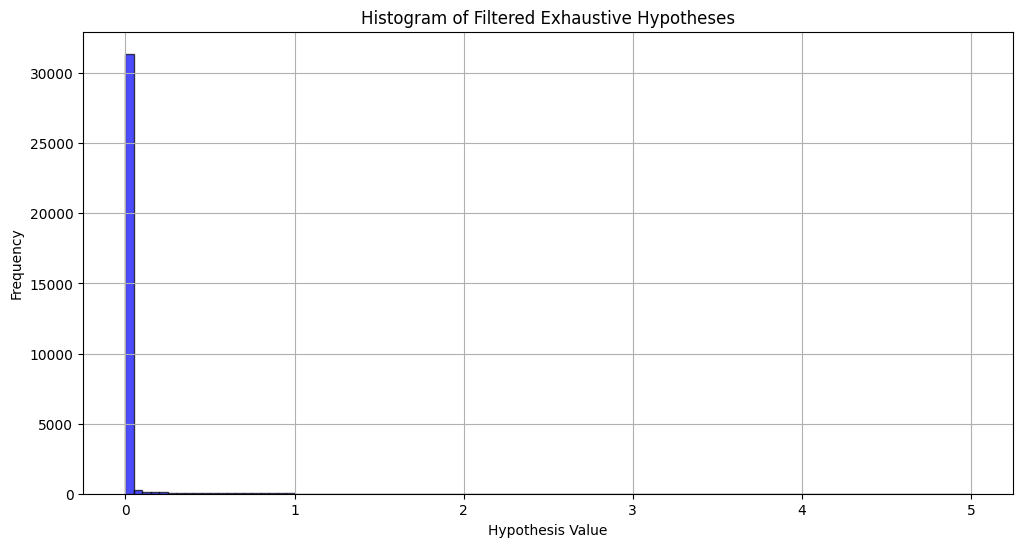

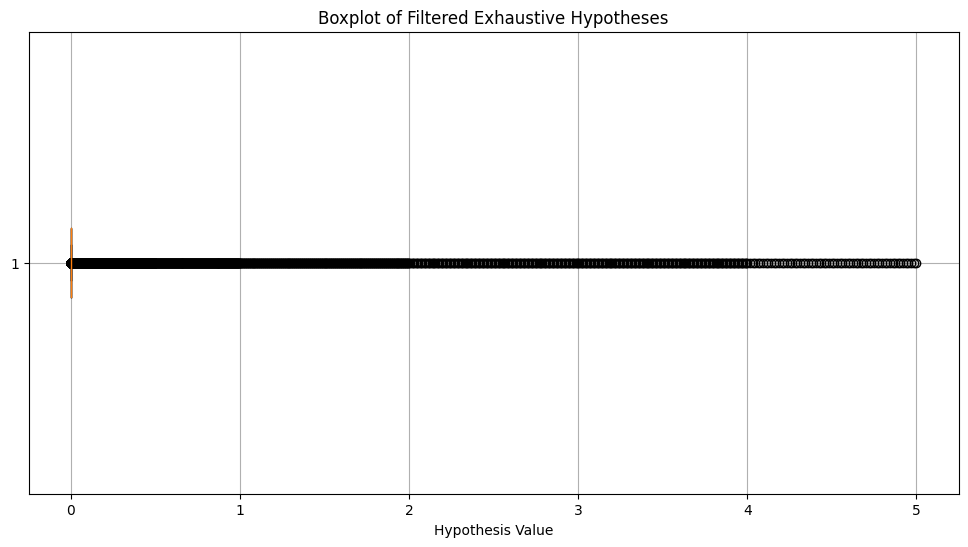

In [2]:
# Importing matplotlib for plotting
import matplotlib.pyplot as plt

# Generate the histogram for the filtered exhaustive hypotheses
plt.figure(figsize=(12, 6))
plt.hist(initial_hypotheses, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Filtered Exhaustive Hypotheses')
plt.xlabel('Hypothesis Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Generate a boxplot to show the range and outliers
plt.figure(figsize=(12, 6))
plt.boxplot(initial_hypotheses, vert=False)
plt.title('Boxplot of Filtered Exhaustive Hypotheses')
plt.xlabel('Hypothesis Value')
plt.grid(True)
plt.show()

In [3]:
def find_closest_hypothesis(hypotheses, target_value):
    """
    Find the closest hypothesis to the target value and the distance to it.

    Parameters:
    hypotheses (list): List of generated hypothesis values.
    target_value (float): The target value (secret weight).

    Returns:
    tuple: Closest hypothesis and its distance from the target value.
    """
    closest_hypothesis = None
    min_distance = float('inf')

    for hypothesis in hypotheses:
        distance = abs(hypothesis - target_value)
        if distance < min_distance:
            min_distance = distance
            closest_hypothesis = hypothesis

    return closest_hypothesis, min_distance

# Example usage
target_value = 0.793281  # Secret target value
closest_hypothesis, distance_to_closest = find_closest_hypothesis(initial_hypotheses, target_value)

print(f"Closest Hypothesis: {closest_hypothesis}")
print(f"Distance to Target Value: {distance_to_closest}")


Closest Hypothesis: 0.79296875
Distance to Target Value: 0.0003122500000000139


In [6]:
import struct
from scipy.stats import pearsonr

def float_to_binary_int(float_value):
    """
    Convert a floating-point value to an integer representing its binary format.
    """
    return struct.unpack('<I', struct.pack('<f', float_value))[0]

def hamming_weight(value):
    """
    Calculate the Hamming weight (number of '1' bits) of a floating-point value.
    """
    int_value = float_to_binary_int(value)
    return bin(int_value).count('1')

# Now you can use the hamming_weight function with floating-point values


def cema(em_traces, inputs, hypotheses):
    num_samples_per_trace = em_traces.shape[1]
    num_traces = em_traces.shape[0]
    best_correlations = np.zeros(len(hypotheses))

    for i, hypothesis in enumerate(hypotheses):
        for trace_index in range(num_traces):
            trace = em_traces[trace_index]
            # Calculate HW for the specific input corresponding to the trace
            input_val = inputs[trace_index]
            hw_value = hamming_weight(input_val * hypothesis)

            # Check if there are enough samples in the trace for correlation
            if len(trace) < 2:
                raise ValueError(f"Not enough samples in trace: Trace length = {len(trace)}")

            correlation, _ = pearsonr(trace, [hw_value]*len(trace))  # Replicate HW value
            best_correlations[i] = max(best_correlations[i], abs(correlation))

    return best_correlations
# Define a function to perform CPA on the given traces and inputs
def perform_cpa(traces, inputs, hypotheses):
    num_traces = len(traces)
    num_samples = len(traces[0])
    num_hypotheses = len(hypotheses)
    correlations = np.zeros((num_hypotheses, num_samples))

    for i, hypothesis in enumerate(hypotheses):
        # Calculate the Hamming weight for each input multiplied by the hypothesis
        hw = np.array([hamming_weight(int(input_val * hypothesis)) for input_val in inputs])

        # Calculate the correlation for each point in the trace
        for j in range(num_samples):
            sample_points = traces[:, j]
            corr, _ = pearsonr(hw, sample_points)
            correlations[i, j] = corr

    return correlations
# Run CEMA analysis
inputs = np.load("cleaned_avg_entries.npy")
traces = np.load("cleaned_avg_entries.npy")
hypotheses = initial_hypotheses
best_correlations = perform_cpa(traces, inputs, hypotheses)
best_correlations

C:\Users\zqde8\CHIPWH~1\cw\home\portable\WPy64-31080\python-3.10.8.amd64\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\zqde8\AppData\Local\Temp\ipykernel_30500\1640671406.py:49: RuntimeWarning: overflow encountered in multiply
  hw = np.array([hamming_weight(int(input_val * hypothesis)) for input_val in inputs])


OverflowError: cannot convert float infinity to integer